# FRAUD DETECTION on ONLINE TRANSACTIONS 


### Project Overview
In this project I trained several models to detect fraud transactions. I have started 5 baseline models. Those are, LogisticRegression, KNeighborsClassifier, RandomForestClassifier, XGBClassifier, SupportVectorMachine Classifier. I continued to optimize top two models based on their train and test accuracy result. XGBoost and RandomForest Models. I have done five iterations including grid search on hyperparameters, balancing the labels by SMOTE and subsampling from the original dataset. Both RandomForest and XGBoost model had over 99% accuracy on the data that includes all frauds and some random safe data. The data was still imbalanced so I did SMOTE over this dataset as well. At the end of those iterations, **XGBoost model had 99% Accuracy Score** on train and **98% Accuracy** on test sets. Accuracy score was calculated by computing Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores.


### Data
I used Kaggle's Paysim dataset. It simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. The original logs were provided by a multinational company, who is the provider of the mobile financial service which is currently running in more than 14 countries all around the world.

**Dataset has fillowing columns:**

**step** - maps a unit of time in the real world. In this case 1 step is 1 hour of time. Total steps 744 (30 days simulation).

**type** - CASH-IN, CASH-OUT, DEBIT, PAYMENT and TRANSFER.

**amount** - amount of the transaction in local currency.

**nameOrig** - customer who started the transaction

**oldbalanceOrg** - initial balance before the transaction

**newbalanceOrig** - new balance after the transaction

**nameDest** - customer who is the recipient of the transaction

**oldbalanceDest** - initial balance recipient before the transaction. Note that there is not information for customers that start with M (Merchants).

**newbalanceDest** - new balance recipient after the transaction. Note that there is not information for customers that start with M (Merchants).

**isFraud** - This is the transactions made by the fraudulent agents inside the simulation. In this specific dataset the fraudulent behavior of the agents aims to profit by taking control or customers accounts and try to empty the funds by transferring to another account and then cashing out of the system.

**isFlaggedFraud** - The business model aims to control massive transfers from one account to another and flags illegal attempts. An illegal attempt in this dataset is an attempt to transfer more than 200.000 in a single transaction.

# 1. Loading Data and EDA

In [1]:
import os
import math
from numpy import * 
import numpy as np
import pandas as pd
import random
import seaborn as sns #for visualization
import matplotlib.pyplot as plt #for visualization

In [2]:
#Load data 
data=pd.read_csv('PS_20174392719_1491204439457_log.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


## EDA with full dataset

In [3]:
#check the shape of the dataset
data.shape

(6362620, 11)

In [4]:
#examine the dataset
data.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [5]:
#Check if there is anu null values
data.isna().sum().sum()


0

In [6]:
#check for duplicate values
data.duplicated(keep='first').any()


False

### Distribution of all Transactions 

Text(0.5, 1.0, 'Distribution of Transactions over the Time')

<Figure size 720x432 with 0 Axes>

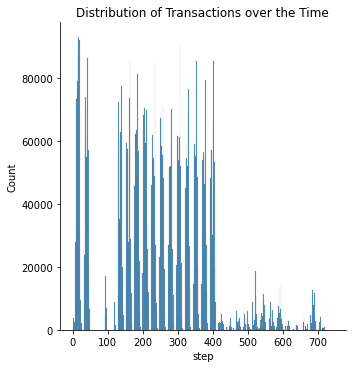

In [7]:
#Distribution of the frequency of all transactions
plt.figure(figsize=(10, 6))
sns.displot(data.step)
plt.title('Distribution of Transactions over the Time')

Distrubition plot shows number of transactions occured each hour (step). There are drastic changes in the number of transactions happens time to time. 

#### Examine the data by the labels
I will filter the data by the labels and examine two groups compairing each other. 

In [8]:
# Filter data by the labels. Safe and Fraud transaction
safe = data[data['isFraud']==0]
fraud = data[data['isFraud']==1]

In [9]:
fraud.shape

(8213, 11)

In [10]:
safe.shape

(6354407, 11)

<Figure size 720x216 with 0 Axes>

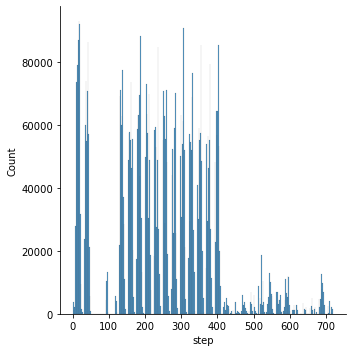

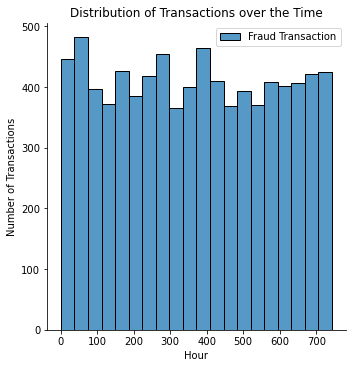

In [11]:
#See the frequency of the transactions for each class on the same plot.
plt.figure(figsize=(10, 3))
sns.displot(safe.step, label="Safe Transaction")
sns.displot(fraud.step, label='Fraud Transaction')
plt.xlabel('Hour')
plt.ylabel('Number of Transactions')
plt.title('Distribution of Transactions over the Time')
plt.legend()

Eventhough safe transactions slows down in 3rd and 4th day and after 16th day of the month, fraud transactions happens at a steady pace. Especially in the second half of the month there are much less safe transactions but number of fraud transactions does not decrease at all.

### Hourly Transaction Amounts

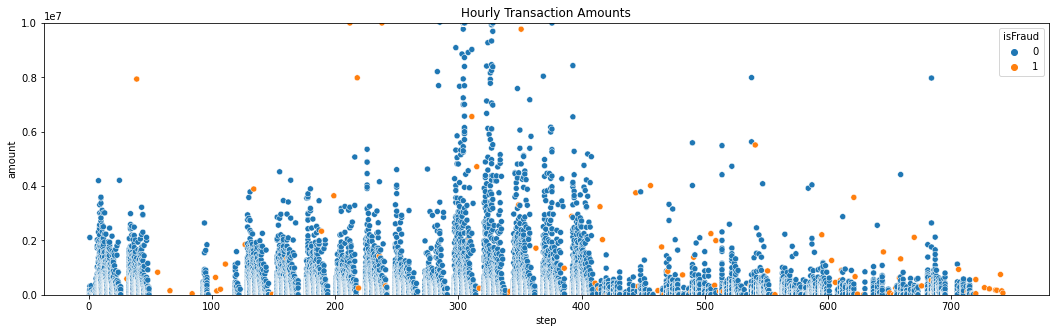

In [12]:
#just use small portion of data to scatterplot the transaction happens every hour and their amount. 
smalldata=data.sample(n=100000, random_state=1)
smalldata=smalldata.sort_index()
smalldata=smalldata.reset_index(drop=True)

#plot the small data
plt.figure(figsize=(18,5))
plt.ylim(0, 10000000)
plt.title('Hourly Transaction Amounts')
ax = sns.scatterplot(x="step", y="amount", hue="isFraud",
                     data=smalldata)

The plot clearly shows that there is some sort of seasonality in the number of transaction during the day. We observe a pattern every 24 hours. we do not know what time of the day '0' represent here but we observe highest transactions clusters around the middle of 24 hour period. It mught be noon or mid day. Lets see if fraud transactions has that kind of pattern.    

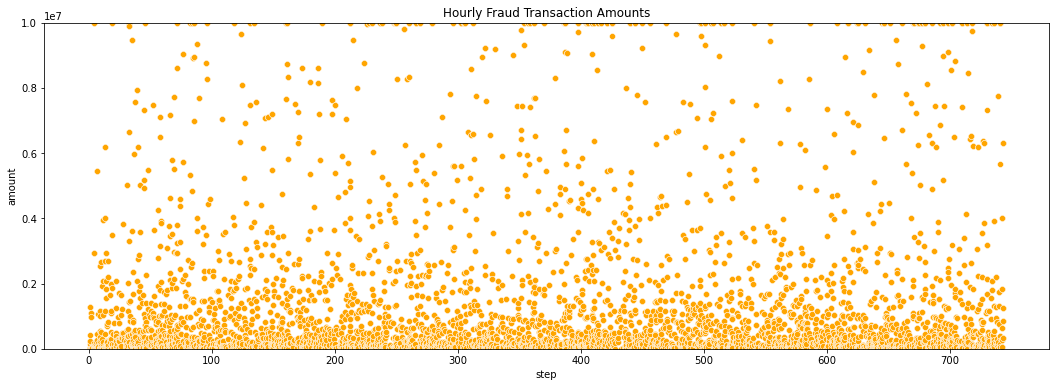

In [13]:
#The hourly amount of al fraud transactions
plt.figure(figsize=(18,6))
plt.ylim(0, 10000000)
plt.title('Hourly Fraud Transaction Amounts')
ax = sns.scatterplot(x="step", y="amount", color='orange',
                     data=fraud)

Fraud transactions does not show that significant pattern like safe ones in terms of number of accurance. They happen every hour almast in the same frequency. There are more fraud transactions in low amounts and less in high amount. But the pattern does not change time to time. 

### Transaction Amount Distributions

C:\Users\Admin\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:title={'center':'Safe Transaction Amount Distribution'}, xlabel='amount', ylabel='Density'>

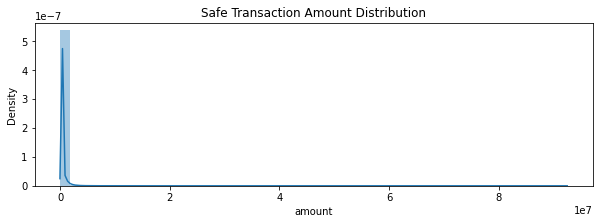

In [19]:
#safe transactions amount distribution plot
plt.figure(figsize=(10,3))
# plt.ylim(0, 0.0000000075)
plt.title('Safe Transaction Amount Distribution')
sns.distplot(safe['amount'])

In [16]:
safe.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

Safe transactions also more often in the low amounts . There is a peek in 1M dolar but above that the frequency decreases. 

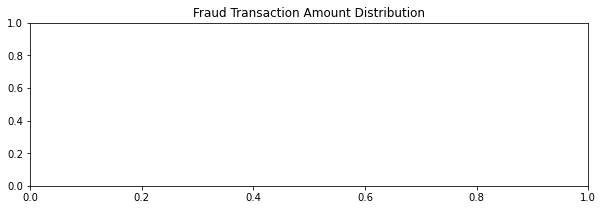

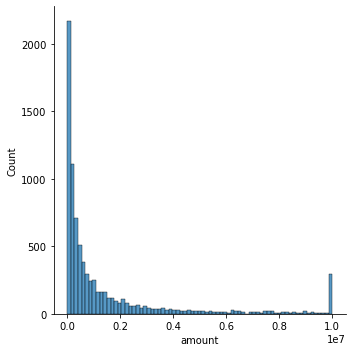

In [20]:
# Fraud transactions amount distribution plot
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
sns.displot(fraud.amount)

There is an interesting peak on 1M$.Lets see how many fraud transactions happens at 1M.

In [21]:
# fraud transactions amount value counts
fraud.amount.value_counts()

10000000.00    287
0.00            16
1165187.89       4
429257.45        4
3242183.64       2
              ... 
7316255.05       1
234377.29        1
42062.82         1
3441041.46       1
4892193.09       1
Name: amount, Length: 3977, dtype: int64

There are fraud transactions in $1M amount for 287 times. And this is the max amount of fraud transactions. 

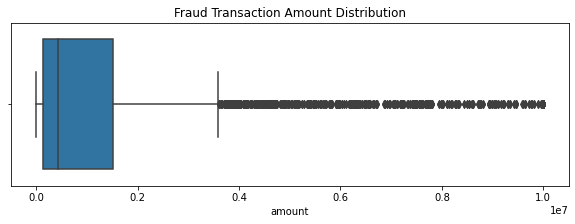

In [22]:
#Fraud transaction boxplot for amount distribution
plt.figure(figsize=(10,3))
plt.title('Fraud Transaction Amount Distribution')
ax = sns.boxplot(x=fraud["amount"])

In [23]:
fraud.amount.describe()

count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

Most of the frauds happens below $400000 so lets check the average amount for those transactions. 

In [24]:
#average amount for frauds below 400K
fraud[fraud.amount<400000].amount.mean()

144912.16828933996


Fraud transaction happens in a large range such as $119 to 10M. The Frequency distribution of Amount of money involved in Fraud transactions is Positively Skewed. Most of the fraud transactions are of Lesser amount. Majority of fraud transactions are lower than 1M. But in 1M there is an interesting increase similar to safe transactions. And that is also max amount in all fraud incidents. There are also some fraud labeled transaction that have 0 amount. This is strange. I want to see those instances, there are 16 of them.

In [25]:
#checking "0" in the fraud  amount
fraud[fraud.amount==0]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736447,212,CASH_OUT,0.0,C1510987794,0.0,0.0,C1696624817,0.00,0.00,1,0
3247298,250,CASH_OUT,0.0,C521393327,0.0,0.0,C480398193,0.00,0.00,1,0
3760289,279,CASH_OUT,0.0,C539112012,0.0,0.0,C1106468520,538547.63,538547.63,1,0
5563714,387,CASH_OUT,0.0,C1294472700,0.0,0.0,C1325541393,7970766.57,7970766.57,1,0
5996408,425,CASH_OUT,0.0,C832555372,0.0,0.0,C1462759334,76759.90,76759.90,1,0
5996410,425,CASH_OUT,0.0,C69493310,0.0,0.0,C719711728,2921531.34,2921531.34,1,0
6168500,554,CASH_OUT,0.0,C10965156,0.0,0.0,C1493336195,230289.66,230289.66,1,0
6205440,586,CASH_OUT,0.0,C1303719003,0.0,0.0,C900608348,1328472.86,1328472.86,1,0
6266414,617,CASH_OUT,0.0,C1971175979,0.0,0.0,C1352345416,0.00,0.00,1,0
6281483,646,CASH_OUT,0.0,C2060908932,0.0,0.0,C1587892888,0.00,0.00,1,0


They are definetely not correct data. But it might have some sort of value such as creating some noise in the transaction traffic to make the real fraud not to be noticed. For that reason I will keep this data.  

### Type of Transactions

<AxesSubplot:>

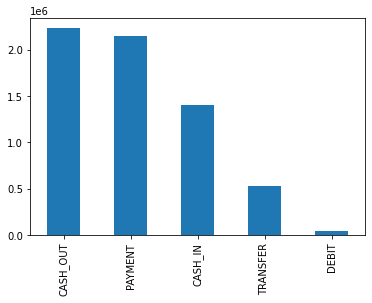

In [26]:
#checking type of  safe transactions
safe.type.value_counts().plot.bar()

<AxesSubplot:title={'center':'Fraudulent Transactions'}>

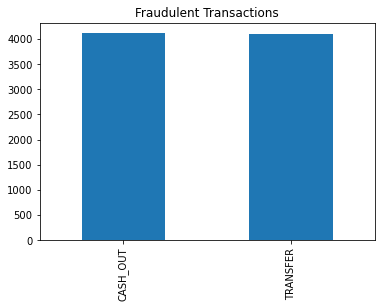

In [27]:
#checking type of fraud transactions
plt.title('Fraudulent Transactions')
fraud.type.value_counts().plot.bar()

Fraud activities only happens with transfer and cash_out transactions. Debit usage is very safe. It will be better to **use only Transfer and Cash_out transaction data** for our model since the other types has no fraud.

### Rate of Fraud Transactions

In [28]:
#proportion of number of frauds 
data.isFraud.value_counts()[1]/(data.isFraud.value_counts()[0]+data.isFraud.value_counts()[1])

0.001290820448180152

Fraud transactions are only 0.01% of the safe transactions. Target class is pretty skewed. It might be problem in the model but we will see. 

In [29]:
data.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

Here we see that the Data is imbalanced and need to be taken care of

In [30]:
#proportion of fraud amount
fraud.amount.sum()/(safe.amount.sum()+fraud.amount.sum())

0.010535206008606473

Total money was stolen is 0.1% of safe transaction amount.

### isFlaggedFraud column

Lets examine the isFlaggedFraud column.

In [31]:
#value counts of isFlaggedFraud column
data.isFlaggedFraud.value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

In [32]:
#there are only 16 positive value. lets see which ones they are. 
data[data.isFlaggedFraud==1]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


All positive values in isFlaggedFraud are also positive on is Fraud Column. There is also inconsistancy in Origin and destination balances on theseinstances.May be that is why they were marked Fraud. It could be valuable information, I will keep it too.  

# 2. Feature Engineering

#### First only get Transfer and Cash_out transaction data
Since fraud transactions happens only in these type of transactions, I will use only that data. 

In [33]:
#filtering only transfer and cash_out data
data_by_type=data[data['type'].isin(['TRANSFER','CASH_OUT'])]

In [34]:
data_by_type

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1,0
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1,0
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0,0
...,...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1,0
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1,0
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1,0
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1,0


### Get 100000 random samples from the filtered data

This data is too big to work with a machine learning algorithm. I will get random subsample from this dataframe just big enough to built a machine learning model. For such project 100000 instance would be good. 

In [35]:
#subsample data , get 100000 instances to train model
df=data_by_type.sample(n=100000, random_state=1)
df=df.sort_index()
df=df.reset_index(drop=True)
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,CASH_OUT,136872.92,C1533123860,162075.98,25203.05,C766572210,217806.00,0.00,0,0
1,1,TRANSFER,367768.40,C288306765,0.00,0.00,C1359044626,370763.10,16518.36,0,0
2,1,CASH_OUT,81029.86,C324112183,0.00,0.00,C288665596,105343.00,8496.61,0,0
3,1,CASH_OUT,53631.83,C1233595751,0.00,0.00,C757108857,83244.00,0.00,0,0
4,1,CASH_OUT,365510.05,C1299327689,0.00,0.00,C564160838,564572.76,1254956.07,0,0


### Dealing with name columns

nameOrig and nameDest columns are supposed to be the names of the peeople. At this moment, they can not be used in machine learning model. But if there is any repeting transaction between two people that might me useful information for classifier.I can create a new column with numeric value with repeat info. Let me check. 

In [36]:
#checking if there is any repeat transaction in between two parties.
list1=np.array(df.nameOrig)
list2=np.array(df.nameDest)
list3=list1+list2
repeat=pd.DataFrame(list3, columns=['comb'])
comb_cnt=repeat.comb.value_counts()
comb_cnt.value_counts()

1    100000
Name: comb, dtype: int64

Well, there is no repeated transaction between 2 parties, each of them are unique. So, we can just drop these string columns.

### Binary encoding the type column

I can use get.dummies() but this faster. 

In [37]:
#drop the name columns
df=df.drop(['nameOrig', 'nameDest'], axis=1)
#Binary-encoding of labelled data in 'type'
df.loc[df.type == 'CASH_OUT', 'type'] = 1
df.loc[df.type == 'TRANSFER', 'type'] = 0
df.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,1,136872.92,162075.98,25203.05,217806.00,0.00,0,0
1,1,0,367768.40,0.00,0.00,370763.10,16518.36,0,0
2,1,1,81029.86,0.00,0.00,105343.00,8496.61,0,0
3,1,1,53631.83,0.00,0.00,83244.00,0.00,0,0
4,1,1,365510.05,0.00,0.00,564572.76,1254956.07,0,0


There is something wrong with the balance information. Eventhough a transaction going on both old and new balance looks '0'.  But I will ignore it for now. 

# 3. Machine Learning

In [38]:
from sklearn.model_selection import train_test_split # import train_test_split function
from sklearn.linear_model import LogisticRegression # import LogisticRegression
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score # import accuracy metrics
from sklearn.ensemble import RandomForestClassifier #import RandomForestClassifier
from sklearn import svm  #import support vector machine classifier
import xgboost as xgb  
from xgboost import  XGBClassifier  #import xgboost classifier 
from sklearn.neighbors import KNeighborsClassifier #import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV # import GridSearchCV
# suppress all warnings
import warnings
warnings.filterwarnings("ignore")

In [39]:
#Slice the target and features from the dataset
features=df.drop('isFraud', axis=1)
target = df.isFraud

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2)

## 3.1. Baseline Models

First, I will run five classification madel with their default parameter to see how each one perform. I put all the classifers into a list and train them in a loop. ml_func function handles all train, evaluation and storing the performence metrics. Also, the data is highly unbalanced, the positive class (frauds) account for 0.01% of all transactions. So I will be measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification. 

In [40]:
# General function to run classifier with default parameters to get baseline model
def ml_func (algoritm):
    #train and fit regression model
    model=algoritm()
    model.fit(X_train, y_train)

    # predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # evaluate
    train_accuracy = roc_auc_score(y_train, train_preds)
    test_accuracy = roc_auc_score(y_test, test_preds)
    report = classification_report(y_test, test_preds)

    print(str(algoritm))
    print("------------------------")
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")

    # store accuracy in a new dataframe
    score_logreg = [algoritm, train_accuracy, test_accuracy]
    models = pd.DataFrame([score_logreg])


In [41]:
X_train['type'] = X_train['type'].astype('int64') 

In [42]:
import warnings
warnings.filterwarnings("ignore")
#list of all classifiers that I will run for base models 
algoritms=[LogisticRegression,KNeighborsClassifier,RandomForestClassifier,XGBClassifier,svm.SVC]

#running each model and print accuracy scores
for algoritm in algoritms:
    ml_func (algoritm)

<class 'sklearn.linear_model._logistic.LogisticRegression'>
------------------------
Training Accuracy: 77.7%
Test Accuracy:     71.59%
<class 'sklearn.neighbors._classification.KNeighborsClassifier'>
------------------------
Training Accuracy: 85.54%
Test Accuracy:     78.32%
<class 'sklearn.ensemble._forest.RandomForestClassifier'>
------------------------
Training Accuracy: 100.0%
Test Accuracy:     80.83%
[15:00:29] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
<class 'xgboost.sklearn.XGBClassifier'>
------------------------
Training Accuracy: 100.0%
Test Accuracy:     83.33%
<class 'sklearn.svm._classes.SVC'>
------------------------
Training Accuracy: 63.07%
Test Accuracy:     61.67%


## 3.2. Grid Search for Best Hyper-Parameter

In the above report we see the best training accuracy is from Random Forest Classifier. On the other hand the best test accuracy is from XGBoost Classifier. I would like to optimize these two model with grid search of multiple parameter values. Grid earch will help me to figure our best parameters to pass to the model to get the most accurate result. I will create a function for grid search named best_param. It will take parameter values and the classifer and print our the best parameter combinations. **I will only run Random Forest and XGBoost models for the rest of the project since they are the best two.**

In [43]:
#A general function for grdi search
def grid_src(classifier, param_grid):
    param_grid=param_grid
    # instantiate the tuned random forest
    grid_search = GridSearchCV(classifier, param_grid, cv=3, n_jobs=-1)

    # train the tuned random forest
    grid_search.fit(X_train, y_train)

    # print best estimator parameters found during the grid search
    print((str(classifier) + 'Best Parameters'))
    print("------------------------")
    print(grid_search.best_params_)
    return grid_search.best_params_

In [44]:
#Grid Search for best parameters of RandomForestClassifier
param_grid_rf = {'n_estimators': [10, 80, 100],
                  'criterion': ['gini', 'entropy'],         
                  'max_depth': [10], 
                  'min_samples_split': [2, 3, 4]
                 }

rf_params=grid_src(RandomForestClassifier(),param_grid_rf)

RandomForestClassifier()Best Parameters
------------------------
{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 100}


In [45]:
#Grid Search for best parameters of XGBClassifier
param_grid_xg = {'n_estimators': [100],
              'learning_rate': [0.05, 0.1], 
              'max_depth': [3, 5, 10],
              'colsample_bytree': [0.7, 1],
              'gamma': [0.0, 0.1, 0.2]
                }
grid_src(XGBClassifier(), param_grid_xg)

[15:08:09] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBClassifier(base_score=None, booster=None, colsample_bylevel=None,
              colsample_bynode=None, colsample_bytree=None, gamma=None,
              gpu_id=None, importance_type='gain', interaction_constraints=None,
              learning_rate=None, max_delta_step=None, max_depth=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              n_estimators=100, n_jobs=None, num_parallel_tree=None,
              random_state=None, reg_alpha=None, reg_lambda=None,
              scale_pos_weight=None, subsample=None, tree_method=None,
              validate_parameters=None, verbosity=None)Best Parameters
------------------------
{'colsample_bytree

{'colsample_bytree': 1,
 'gamma': 0.0,
 'learning_rate': 0.1,
 'max_depth': 5,
 'n_estimators': 100}

### Run models with their best parameters

In [50]:
#a function to train and evaluate a  model with given datasets 
#it also prints the accuracy scores 
import scikitplot as skplt
def run_model(model, X_train, y_train,X_test, y_test ):
    model.fit(X_train, y_train)

    # predict
    train_preds = model.predict(X_train)
    test_preds = model.predict(X_test)

    # evaluate
    train_accuracy = roc_auc_score(y_train, train_preds)
    test_accuracy = roc_auc_score(y_test, test_preds)
    report = classification_report(y_test, test_preds)
#     F_Beta = fbeta_score(y_test, test_preds, beta=2.0)

    #print reports of the model accuracy
    print('Model Scores')
    print("------------------------")
#     print('F-Beta Score : \n', F_Beta)
    print("------------------------")
    print(f"Training Accuracy: {(train_accuracy * 100):.4}%")
    print(f"Test Accuracy:     {(test_accuracy * 100):.4}%")
    print("------------------------------------------------------")
    print('Classification Report : \n', report)

In [51]:
# Running RandomForestClassifier with best parameters
rf_model=RandomForestClassifier(n_estimators=10, 
                                  criterion= 'entropy', 
                                  max_depth= 10, 
                                  min_samples_split= 4)
                               
                               
run_model(rf_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
------------------------
Training Accuracy: 88.53%
Test Accuracy:     80.0%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19940
           1       1.00      0.60      0.75        60

    accuracy                           1.00     20000
   macro avg       1.00      0.80      0.87     20000
weighted avg       1.00      1.00      1.00     20000



The accuracy dropped because I set max_depth to 10. This is kind of cut off for the model to stop after that point. The result with defauul value is higher because it goes unlimited until all leaves are the purist level. But it will take too long for a big dataset. I will keep this parameter and try to improve. 

In [52]:
# Running XGBClassifier with best parameters
xgb_model=XGBClassifier(colsample_bytree= 0.7, 
                        n_estimators= 100,
                        gamma= 0.0,
                        learning_rate=0.1,
                        max_depth=5
                        )
                                                                 
run_model(xgb_model, X_train, y_train,X_test, y_test)

[15:17:14] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Scores
------------------------
------------------------
Training Accuracy: 90.6%
Test Accuracy:     81.67%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      1.00      1.00     19940
           1       1.00      0.63      0.78        60

    accuracy                           1.00     20000
   macro avg       1.00      0.82      0.89     20000
weighted avg       1.00      1.00      1.00     20000



XGBoost definetely works better with the best parameters set. 

Randomforest classifier might be effected the skewness of the target. Our data is quite unbalanced. That skewness can be taken care by resampling the data via SMOTE. 



## Using Stratified K-fold 

In [ ]:
X = df.drop(['isFraud'],axis=1)
Y = df['isFraud']

In [ ]:
from sklearn.model_selection import StratifiedKFold
accuracy = []
skf = StratifiedKFold(n_splits=10,random_state=None)
skf.get_n_splits(X, Y)
for train_index, test_index in skf.split(X,Y):
    print("TRAIN:", train_index, "TEST:", test_index)
    Xnew_train, Xnew_test = X[train_index], X[test_index]
    ynew_train, ynew_test = Y[train_index], Y[test_index]

### 3.3.1. Balancing Data via Oversampling with SMOTE

In [53]:
from imblearn.over_sampling import SMOTE

# view previous class distribution
print(target.value_counts()) 

sm = SMOTE(random_state=42)
# resample data ONLY using training data
X_resampled, y_resampled = sm.fit_resample(X_train, y_train) 

# view synthetic sample class distribution
print(pd.Series(y_resampled).value_counts()) 

0    99722
1      278
Name: isFraud, dtype: int64
0    79782
1    79782
Name: isFraud, dtype: int64


In [54]:
# perform  train-test-split over resampled data
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, random_state=0)

### Running models with the balanced data with best parameters

In [55]:
#Running RainForest Model with resampled data
run_model(rf_model, X_train, y_train,X_test, y_test)

Model Scores
------------------------
------------------------
Training Accuracy: 99.13%
Test Accuracy:     99.06%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.98      0.99     19719
           1       0.98      1.00      0.99     20172

    accuracy                           0.99     39891
   macro avg       0.99      0.99      0.99     39891
weighted avg       0.99      0.99      0.99     39891



In [56]:
#Running XGBoost Model with resampled data
run_model(xgb_model, X_train, y_train,X_test, y_test)

[15:17:47] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Scores
------------------------
------------------------
Training Accuracy: 99.58%
Test Accuracy:     99.46%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       1.00      0.99      0.99     19719
           1       0.99      1.00      0.99     20172

    accuracy                           0.99     39891
   macro avg       0.99      0.99      0.99     39891
weighted avg       0.99      0.99      0.99     39891



Woww, the performence increased dramatically for both models. Having almost 100% accuracy is suspicious though. It is probably because of the synthetic data that SMOTE created. Since there are only small amount of instances for fraud class, it created too many of the same data. Model memorize that pattern and gives perfect result on the test set. Because, there is highly possible that same data points are also availble in the test set. 

### 3.3.2. Subsampling Data from the Original Dataset

I had a huge dataset at the beginning and I did random sampling to reduce the computational laod. But I have a lot more natural fraud data point in this dataset that I can use. Insted of creating syntetic data I will choose those pints and randomly choose the safe transaction data points to get less skewed sample for my models. 

In [57]:
#Filter the only types that fraud transaction occurs
data2=data[data['type'].isin(['TRANSFER','CASH_OUT'])]
#Slice data in to fraud and safe by isFraud values
safe_2 = data2[data2['isFraud']==0]
fraud_2 = data2[data2['isFraud']==1]
#get 50000 random sample from the safe transactions 
safe_sample=safe_2.sample(n=50000, random_state=1)
safe_sample=safe_sample.sort_index()
safe_samplef=safe_sample.reset_index(drop=True)
#combine all fraud observation and 50000 safe transaction data in to df3
df3=pd.concat([safe_sample,fraud_2])
df3.reset_index(drop=True)
#drop name columns
df3=df3.drop(['nameOrig', 'nameDest'], axis=1)
#Binary-encoding of labelled data in 'type'
df3.loc[df3.type == 'CASH_OUT', 'type'] = 1
df3.loc[df3.type == 'TRANSFER', 'type'] = 0
df3.head()

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
78,1,0,42712.39,10363.39,0.0,57901.66,24044.18,0,0
93,1,0,583848.46,0.00,0.0,667778.00,2107778.11,0,0
159,1,1,154716.20,0.00,0.0,187433.00,3461666.05,0,0
162,1,1,267148.82,0.00,0.0,641975.35,1178808.14,0,0
191,1,1,55105.90,0.00,0.0,317952.89,2719172.89,0,0


In [58]:
#check class labels
df3.isFraud.value_counts()

0    50000
1     8213
Name: isFraud, dtype: int64

Ok, the new dataset with totally natural data is ready for going in to our models. The proportion is still not 50% but good enough to train a model. 

### Running models with subsampled natural data

In [59]:
#Slide the target and features from the dataset
features2=df3.drop('isFraud', axis=1)
target2 =df3.isFraud
# split the data into train and test
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

In [60]:
# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
------------------------
Training Accuracy: 94.04%
Test Accuracy:     94.19%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     10026
           1       0.98      0.89      0.93      1617

    accuracy                           0.98     11643
   macro avg       0.98      0.94      0.96     11643
weighted avg       0.98      0.98      0.98     11643



In [61]:
X_train2.dtypes

step                int64
type               object
amount            float64
oldbalanceOrg     float64
newbalanceOrig    float64
oldbalanceDest    float64
newbalanceDest    float64
isFlaggedFraud      int64
dtype: object

In [62]:
X_train2['type'] = X_train2['type'].astype('int64') 

In [63]:
# Running XGBClassifier with best parameters

run_model(xgb_model, X_train2, y_train2,X_test2, y_test2)


[15:43:37] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Scores
------------------------
------------------------
Training Accuracy: 98.62%
Test Accuracy:     97.79%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      1.00      0.99     10026
           1       0.97      0.96      0.97      1617

    accuracy                           0.99     11643
   macro avg       0.98      0.98      0.98     11643
weighted avg       0.99      0.99      0.99     11643



The results look much realistic. I can still use SMOTE on this new dataset and see how it effects the results now. But XGBoost model seems to be working clearly better in any set of data so far. Eventhough we have better proportion we still have unbalanced data. We can permofm oversampling on this new data to have more fraud data. 

### 3.3.3 Performing SMOTE on the New Data

In [64]:
from imblearn.over_sampling import SMOTE

# view previous class distribution
print(target2.value_counts()) 

sm = SMOTE(random_state=42)
# resample data ONLY using training data
X_resampled2, y_resampled2 = sm.fit_resample(X_train2, y_train2) 

# view synthetic sample class distribution
print(pd.Series(y_resampled2).value_counts()) 
X_train2, X_test2, y_train2, y_test2 = train_test_split(features2, target2, test_size=0.2)

0    50000
1     8213
Name: isFraud, dtype: int64
0    39974
1    39974
Name: isFraud, dtype: int64


### Running models with subsampled and oversampled data

In [65]:
# Running RandomForestClassifier with best parameters
run_model(rf_model, X_train2, y_train2,X_test2, y_test2)

Model Scores
------------------------
------------------------
Training Accuracy: 94.39%
Test Accuracy:     94.11%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.98      1.00      0.99     10013
           1       0.99      0.88      0.93      1630

    accuracy                           0.98     11643
   macro avg       0.98      0.94      0.96     11643
weighted avg       0.98      0.98      0.98     11643



In [66]:
X_train2['type'] = X_train2['type'].astype('int64')

In [67]:
# Running XGBClassifier with best parameters
run_model(xgb_model, X_train2, y_train2,X_test2, y_test2)

[15:43:42] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.4.0/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Model Scores
------------------------
------------------------
Training Accuracy: 98.6%
Test Accuracy:     98.13%
------------------------------------------------------
Classification Report : 
               precision    recall  f1-score   support

           0       0.99      1.00      1.00     10013
           1       0.98      0.97      0.97      1630

    accuracy                           0.99     11643
   macro avg       0.99      0.98      0.98     11643
weighted avg       0.99      0.99      0.99     11643



XGBoost improved a little bit more but Random Forest accuracy decreased with this new data. I can say that Random Forest can not handling too many repeted data for the sake of balancing

In [69]:
#### Generating Model
import pickle
file_name = "xgb_class.pkl"

# save
pickle.dump(xgb_model, open(file_name, "wb"))

# load
xgb_model_loaded = pickle.load(open(file_name, "rb"))

# 4. Machine Learning Pipeline

Pipelines are extremely useful tools to write clean and manageable code for machine learning.Creating a model takes a many steps such as clean our data, transform it, potentially use feature selection, and then run a machine learning algorithm. Using pipelines, we can do all these steps in one go!

In [ ]:
#Load necessary libraries for ml pipeline
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA

In [ ]:
import warnings
warnings.filterwarnings('ignore')
# Create the pipeline
pipe = Pipeline([('scl', MinMaxScaler()),
                ('pca', PCA(n_components=7)),
                ('xgb', XGBClassifier())])

# Create the grid parameter
grid = [{'xgb__n_estimators': [100],
         'xgb__learning_rate': [0.05, 0.1], 
         'xgb__max_depth': [3, 5, 10],
         'xgb__colsample_bytree': [0.7, 1],
         'xgb__gamma': [0.0, 0.1, 0.2]
                }]
                                 
# Create the grid, with "pipe" as the estimator
gridsearch = GridSearchCV(estimator=pipe,
                  param_grid=grid,
                  scoring='accuracy',
                  cv=3)

# Fit using grid search
gridsearch.fit(X_train, y_train)

# Best accuracyprint('\nBest params:\n', gridsearch.best_params_)

print('Best accuracy: %.3f' % gridsearch.best_score_)

# Best params


# 5. Feature Importance

Lets check whick features are the most influencial ones for both model. 

In [ ]:
# plot the important features - based on Random Forest
feat_importances = pd.Series(rf_model.feature_importances_, index=features.columns)
ax.set_ylabel('features', size = 16);
feat_importances.nlargest(10).sort_values().plot(kind='barh', figsize=(10,5))
plt.xlabel('Relative Feature Importance for Random Forest');
plt.title('Feature Importance Order', size = 16);

In [ ]:
# plot the important features - based on XGBOOST
from xgboost import plot_importance

fig = plt.figure(figsize = (10, 6))
ax = fig.add_subplot(111)
colours = plt.cm.Set1(np.linspace(0, 1, 9))
ax = plot_importance(xgb_model, height = 0.5, color = 'orange', grid = False, \
                     show_values = False, importance_type = 'cover', ax = ax);
for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)        
ax.set_xlabel('Relative Feature Importance for XGBoost', size=12);
ax.set_yticklabels(ax.get_yticklabels(), size = 12);
ax.set_title('Feature Importance Order', size = 16);

Each model gives different importance to the features. But oldbalanceOrg and newbalanceDest are the major indicators for both models. 

# 6. Conclusion

### Accuracy results after iterations
I created a model that can predict fraud transactions. I used XGBoost and RandomForest  classifiers in this model. 

      (Data & Parameters)                              (Accuracy)   XGBoost   RandomForest
      **Iteration 1**                                                            
    - Random Sample & default parameters                                87%       86%               
      **Iteration 2** 
    - Random Sample & best parameters                                   99.5%     84.3%
      **Iteration 3**
    - Balanced data with SMOTE & best parameters                        99.4%     98.7% 
      **Iteration 4**
    - Random Safe trans. data and all Fraud data & best parameters      98.8%     99.6%
      **Iteration 5**
    - New data balanced with SMOTE & best parameters                    99%       92.1%


Performence has increased after five iterations and finally reached to; 
### 99% accuracy with XGBoost Classifier and Balanced Data


### Most Influential Features
- Most important features are senders balance before the transaction (oldBalanceOrig) and receivers balance after the transaction (newBalanceDest). 


### EDA Findings

- Eventhough safe transactions slows down in 3rd and 4th day and after 16th day of the month, fraud transactions happens at a steady pace. Especially in the second half of the month there are much less safe transactions but number of fraud transactions does not decrease at all. 
- Fraud proportion over all transactions is 0.01% while the fraud amount proportion is 0.1%
- There is some sort of seasonality in the number of transaction every 24 hours.Fraud transactions does not show that significant pattern. They happen every hour almost in the same frequency.
- There are more fraud transactions in low amounts and less in high amount. This distribution does not change much.
- Fraud transaction happens in a large range such as 119 dolars to 10M dolars. Most of the fraud transactions are of Lesser amount. But in 1M there is an interesting increase similar to safe transactions. 
- There are 16 fake fraud cases  with '0' amount.
- Fraud activities only happens with TRANSFER and CASH_OUT transactions. DEBIT usage is very safe.



# 7.Future Work

- I would like reindex this dataset with timestapms and analyze it as time series. I believe I would find some seosonality on both fraud transaction frequency and amount as well. 